## Data Scraping

As a first step we will scrape the necessary data to proceed, namely:
- titles for each author that are publicly available
- publishing year, if it is stored in the metadata
- text strings split into single chapters

In [1]:
from bs4 import BeautifulSoup
import requests

In [1]:
import pandas as pd

In [3]:
from src.scraping import scrape_titles_years
from src.utils import dict_to_csv, csv_to_dict

In [4]:
authors_df = pd.read_csv('data/authors.csv')
titles_years_list = []
for url in authors_df.author_url:
    titles_years_list.extend(scrape_titles_years(url))

df = pd.DataFrame(data = titles_years_list, columns = ['author_url', 'title', 'title_url', 'year'])
df.to_csv('data/titles.csv', index=False)

In [3]:
titles_df = pd.read_csv('data/titles.csv')

In [4]:
from src.scraping import scrape_chapters

In [6]:
chapters_list = []
for title in titles_df.title_url:
    chapters_list.append(scrape_chapters(title))

df = pd.DataFrame(data = chapters_list, columns = ['title_url',
                                              'chapter_num',
                                              'chapter'])
df.to_csv('data/chapters.csv', index=False) 

## Using API's
If scraping the years from projekt-gutenberg.org does not yield any results, we'll have to rely on API's. Trying to avoid that because of hard limits though.

In [ ]:
from src.utils import PrivateKeysHandler

In [22]:
relative_path_to_file = '.env'
keys = PrivateKeysHandler(relative_path_to_file)
api_key_dict = keys.load_keys('APIs')

In [52]:
# import requests

# url = "https://google-web-search.p.rapidapi.com/"

# querystring = {"query":"theodor+fontane+effi+briest","max":"1"}

# headers = {
# 	"X-RapidAPI-Key": api_key_dict['google_web_search_key'],
# 	"X-RapidAPI-Host": "google-web-search.p.rapidapi.com"
# }

# response = requests.request("GET", url, headers=headers, params=querystring)

# print(response.text)

{"search_term":"theodor+fontane+effi+briest","search_site":null,"knowledge_panel":{"name":"Effi Briest","label":"Novel by Theodor Fontane","description":{"text":"Effi Briest is a realist novel by Theodor Fontane. Published in book form in 1895, Effi Briest marks both a watershed and a climax in the poetic realism of literature.","url":"https:\/\/en.wikipedia.org\/wiki\/Effi_Briest","site":"Wikipedia"},"image":{"url":"https:\/\/encrypted-tbn0.gstatic.com\/images?q=tbn:mP-X_DD_yDH2zM","width":181,"height":278,"page_url":"https:\/\/books.google.com\/books\/about\/Effi_Briest.html?id=OYX5JoRGQkoC&source=kp_cover"},"info":[{"title":"Originally published","labels":["1894"]},{"title":"Author","labels":["Theodor Fontane"]},{"title":"Genre","labels":["Novel"]},{"title":"Adaptations","labels":["Effi Briest (1974)","The False Step (1939)"]}]},"results":[{"position":1,"url":"https:\/\/en.wikipedia.org\/wiki\/Effi_Briest","title":"Effi Briest - Wikipedia","description":"Effi Briest is a realist nov

In [59]:
#int(response.json()['knowledge_panel']['info'][0]['labels'][0])

1894

## Filter Data
Now we will filter our data. For this we'll merge our 3 dataframes. We will left join, because there are authors in the authors dataframe which do not have any title/chapter in the other dataframes.

In [20]:
chapters = pd.read_csv('data/chapters.csv')
authors = pd.read_csv('data/authors.csv')
titles = pd.read_csv('data/titles.csv')

In [22]:
df = (chapters.merge(titles, on='title_url', how='left')
      .merge(authors, on='author_url', how='left')
     )

In [23]:
df.head()

,title_url,chapter_num,chapter,author_url,title,year,author,born,died
0,/gellert/comoedia/comoedia.html,0,"Man hat zu unsern Zeiten, besonders in Frankre...",gellert,Pro comoedia commovente,1751,Christian Fürchtegott Gellert,1715,1769
1,/gellert/comoedia/comoedia.html,1,Ich komme nunmehr auf den zweiten Einwurf. Rüh...,gellert,Pro comoedia commovente,1751,Christian Fürchtegott Gellert,1715,1769
2,/gellert/comoedia/comoedia.html,2,Bei jeder Erdichtung nemlich verursacht nicht ...,gellert,Pro comoedia commovente,1751,Christian Fürchtegott Gellert,1715,1769
3,/gellert/zschwest/zschwest.html,0,"CleonDer Magister, sein BruderLottchen, Cleons...",gellert,Die zärtlichen Schwestern,1747,Christian Fürchtegott Gellert,1715,1769
4,/gellert/zschwest/zschwest.html,1,"Cleon. Lottchen.Lottchen. Lieber Papa, Herr Da...",gellert,Die zärtlichen Schwestern,1747,Christian Fürchtegott Gellert,1715,1769


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37313 entries, 0 to 37312
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title_url    37313 non-null  object
 1   chapter_num  37313 non-null  int64 
 2   chapter      36682 non-null  object
 3   author_url   37313 non-null  object
 4   title        37313 non-null  object
 5   year         36708 non-null  object
 6   author       37313 non-null  object
 7   born         37313 non-null  int64 
 8   died         37313 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.8+ MB


We see that some chapters do not contain any values. This might be due to some illustrations or different html-structures. 

In [27]:
df = df.loc[~df.chapter.isna()]

In [30]:
df.loc[df.year.isna()].head()

,title_url,chapter_num,chapter,author_url,title,year,author,born,died
6678,/diderot/rameaus/rameaus.html,0,Mit Zeichnungen von Antoine Watteau»Rameaus Ne...,goethe,Rameaus Neffe,NaN,Johann Wolfgang von Goethe,1749,1832
6679,/diderot/rameaus/rameaus.html,1,"Es mag schön oder häßlich Wetter sein, meine G...",goethe,Rameaus Neffe,NaN,Johann Wolfgang von Goethe,1749,1832
6680,/diderot/rameaus/rameaus.html,2,"Der Übersetzer hatte sich vorgenommen, die Per...",goethe,Rameaus Neffe,NaN,Johann Wolfgang von Goethe,1749,1832
6681,/diderot/rameaus/rameaus.html,3,Nachdem die französische Übersetzung des Dider...,goethe,Rameaus Neffe,NaN,Johann Wolfgang von Goethe,1749,1832
7217,/lenz/empfinds/empfinds.html,0,oder \n\n,lenz,Empfindsamster aller Romane,NaN,Jakob Lenz,1751,1792


Also some of the rows do not have a year-value. After looking into it, a possible reason is that the metadata for 'firstpub' exists, but only consists of an empty string. We can tweak the data collection code for this later.

In [31]:
df = df.loc[~df.year.isna()]

In some collections (often collections of poems) there are title pages where 'Projekt Gutenberg' is mentioned. This doesn't belong to the original book.

In [33]:
df = df.loc[~df.chapter.str.contains('Projekt Gutenberg')]

For the first iteration it is enough for us to consider books where the year of first publishment was already given in the metadata of the webpage. We assigned the values 0 (for missing firstpub-data / or data in the wrong format) and 2 (url status_code different from 200) to titles with missing years.

Because of some missing years, we first have to convert the year-data into integer values.

In [36]:
#df['year'] = pd.to_numeric(df['year'])

ValueError: Unable to parse string "1800-1801" at position 1508

We are unable to do so, because some strings are of the form 
- '1800-1801' or
- '1778/79' or
- '1854/1855'. 
To keep things simple, we will just keep the first numbers (first 4 characters).

In [42]:
df.loc[df.year.str.len() >4].sample(50)

,title_url,chapter_num,chapter,author_url,title,year,author,born,died
7913,/herder/volklied/volklied.html,121,Spanisch.Aus Gongora Romanc. Liricos p. 328.O ...,herder,Stimmen der Völker in Liedern,1778/79,Johann Gottfried Herder,1744,1803
36940,/musil/mannohne/mannohne.html,98,"Aus einem Staat, der an einem Sprachfehler zug...",musil,Der Mann ohne Eigenschaften. Erstes Buch,1930 - 1932,Robert Musil,1880,1942
28288,/gotthelf/annebae2/annebae2.html,9,"Der Bub ward plötzlich krank, das heißt, man w...",gotthelf,Wie Anne Bäbi Jowäger haushaltet und wie es ih...,1843/44,Jeremias Gotthelf,1797,1854
1759,/wieland/aristipp/aristipp.html,180,"Ich für meine Person, wurde auf eine angenehme...",wieland,Aristipp,1800-1801,Christoph Martin Wieland,1733,1813
1753,/wieland/aristipp/aristipp.html,174,"Der Platonische Sokrates hat, seinem eigenen m...",wieland,Aristipp,1800-1801,Christoph Martin Wieland,1733,1813
7651,/herder/humanita/humanita.html,9,Sechstes Fragment\n Wiederauflebung der ...,herder,Briefe zu Beförderung der Humanität,1793 - 1797,Johann Gottfried Herder,1744,1803
29286,/gutzkow/zauber6/zauber6.html,1,Als im ersten Beginn des diesjährigen Frühling...,gutzkow,"Der Zauberer von Rom, 6. Buch",1858-61,Karl Gutzkow,1811,1878
7850,/herder/volklied/volklied.html,58,"Deutsch.Es ist kein lieber Ding auf Erden,\n ...",herder,Stimmen der Völker in Liedern,1778/79,Johann Gottfried Herder,1744,1803
7936,/herder/volklied/volklied.html,144,"Spanisch.S. hist. de las guerr. Civil, p. 463....",herder,Stimmen der Völker in Liedern,1778/79,Johann Gottfried Herder,1744,1803
36847,/musil/mannohne/mannohne.html,5,"Ulrich Der Mann ohne Eigenschaften, von dem hi...",musil,Der Mann ohne Eigenschaften. Erstes Buch,1930 - 1932,Robert Musil,1880,1942


In [43]:
df.loc[df.year.str.len() > 4, 'year'] = df.loc[df.year.str.len() > 4, 'year'].str[:4]
df['year'] = pd.to_numeric(df['year'])

In [47]:
df = df.loc[df.year > 10]

Unfortunately this was quite a chunk. But we can come back to the year in the second iteration.

As we only care for the first publishment year, we will only consider publishments when the author was still alive, i.e. 'born' < 'year' < 'died'. Otherwise it is too likely that we have a later edition or a collection of works.

In [50]:
df = df.loc[(df.born < df.year) & (df.year < df.died)]

Lastly, we check for duplicates that might have emerged from merging the dataframes.

In [57]:
df.duplicated().sum() #that hurt

9237

In [58]:
df.drop_duplicates(inplace=True)

In [62]:
df = df.drop(columns= ['title', 'author_url', 'born', 'died']) 

In [64]:
cols = ['author', 'chapter', 'year', 'chapter_num', 'title_url']
df = df[cols]

In [69]:
df.to_csv('data/df_filtered.csv', index=False)

## Clean chapters
It is time to look at the chapters themselves. We already know that there are a lot of unnecessary newlines and spaces. So we start by removing them.

In [1]:
import pandas as pd

In [2]:
ch = pd.read_csv('data/df_filtered.csv')

In [6]:
ch.duplicated(subset = 'chapter').sum()

1547

In [8]:
ch = ch.drop_duplicates(subset='chapter')

In [9]:
ch.chapter.str.len().describe()

count     11412.000000
mean      12955.755433
std       18038.578299
min           1.000000
25%        2845.500000
50%       10365.500000
75%       15666.500000
max      544455.000000
Name: chapter, dtype: float64

In [10]:
ch.year.describe()

count    11412.000000
mean      1832.650894
std         44.215251
min       1746.000000
25%       1800.000000
50%       1827.000000
75%       1865.000000
max       1937.000000
Name: year, dtype: float64

In [11]:
ch.year.value_counts()

1805    679
1816    586
1827    275
1812    266
1800    258
       ... 
1759      2
1937      2
1802      2
1909      1
1820      1
Name: year, Length: 166, dtype: int64

In [12]:
ch.loc[ch.year == 1805, 'author'].value_counts()

Achim von Arnim     678
Clemens Brentano      1
Name: author, dtype: int64

In [89]:
from matplotlib import pyplot as plt

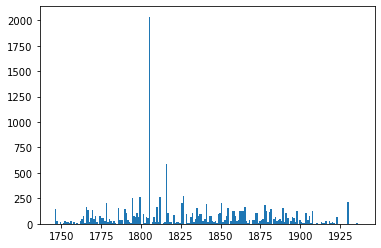

In [83]:
plt.hist(ch.year, bins=198)
plt.show()

# Simple base model
Today we'll get an MVP in a very simple fashion:

#### Tokenizing
- tokenize each chapter using the word_tokenize method from nltk
- keep tokens that have only letters with the string method .isalpha()
- keep chapters with enough tokens, say 50
- take the first 500 tokens for testing

#### Base model


In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [16]:
test_chapter = ch.chapter[0]

In [22]:
test_chapter.lower()

'man hat zu unsern zeiten, besonders in frankreich, eine art von lustspielen versucht, welche nicht allein die gemüter der zuschauer zu ergötzen, sondern auch so zu rühren und so anzutreiben vermögend wäre, daß sie ihnen sogar tränen auspresse. man hat dergleichen komödie, zum scherz und zur verspottung, in der französischen sprache comédie larmoyante, das ist die weinerliche, genennt, und von nicht wenigen pflegt sie als eine abgeschmackte nachäffung des trauerspiels getadelt zu werden. ich bin zwar nicht willens, alle und jede stücke, welche in diese klasse können gebracht werden, zu verteidigen; sondern ich will bloß die art der einrichtung selbst retten und womöglich erweisen, daß die komödie, mit allem ruhme, heftiger bewegen könne. dacier und andre, welche die von dem aristoteles entworfene erklärung weitläuftiger haben erläutern wollen, setzen die ganze kraft und stärke der komödie in das lächerliche. nun kann man zwar nicht leugnen, daß nicht der größte teil derselben darauf an

In [26]:
tokens = nltk.tokenize.word_tokenize(test_chapter.lower(), language='german')

In [48]:
fdist = nltk.FreqDist([word for word in tokens[:500] if word.isalpha()])

In [85]:
fdist

FreqDist({'die': 15, 'und': 15, 'der': 12, 'nicht': 10, 'zu': 8, 'in': 7, 'daß': 7, 'komödie': 7, 'eine': 6, 'welche': 6, ...})

In [51]:
ch['tokens'] = ch['chapter'].apply(lambda x: nltk.tokenize.word_tokenize(x.lower(), language='german'))

In [53]:
ch['tokens'] = ch['tokens'].apply(lambda x: [word for word in x if word.isalpha()])

In [55]:
ch['token_num'] = ch['tokens'].apply(lambda x: len(x))

In [56]:
ch['token_num'].describe()

count    11412.000000
mean      1972.970820
std       2757.233646
min          0.000000
25%        413.000000
50%       1561.000000
75%       2419.250000
max      93052.000000
Name: token_num, dtype: float64

In [64]:
ch = ch.loc[~((ch.token_num < 100) &(ch.chapter_num == 0))]

In [68]:
ch = ch.loc[~(ch.token_num == 0)]

In [69]:
ch['token_num'].describe()

count    11252.000000
mean      2000.793192
std       2766.807870
min          1.000000
25%        455.000000
50%       1586.000000
75%       2431.500000
max      93052.000000
Name: token_num, dtype: float64

In [75]:
ch = ch.loc[~(ch.token_num < 50)]

In [83]:
ch.token_num.describe()

count    10963.000000
mean      2052.707288
std       2784.259775
min         50.000000
25%        532.500000
50%       1635.000000
75%       2461.000000
max      93052.000000
Name: token_num, dtype: float64

In [84]:
ch['test_tokens'] = ch.apply(lambda x: x.tokens[:500] if x.token_num > 500 else x.tokens, axis=1)

In [131]:
ch['decade'] = ch['year'].apply(lambda x: str(x)[:3] + '0')

In [95]:
ch.decade.value_counts()

1800s    1154
1810s    1036
1850s     905
1790s     848
1870s     710
1770s     698
1880s     686
1860s     674
1830s     670
1820s     641
1840s     569
1760s     524
1890s     414
1900s     411
1780s     339
1930s     214
1740s     181
1750s     116
1910s      94
1920s      79
Name: decade, dtype: int64

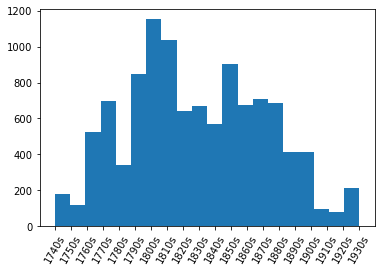

In [106]:
plt.hist(ch.decade.sort_values(), bins= 20)
plt.xticks(rotation = 60)
plt.xticks(['1740s', '1750s', '1760s', '1770s', '1780s', '1790s',
            '1800s', '1810s', '1820s', '1830s', '1840s', 
            '1850s', '1860s', '1870s', '1880s', '1890s', 
            '1900s', '1910s', '1920s', '1930s']) 
plt.show()

we see some issue here: a major part of the chapters was written in the 19th century. We don't care about that for now, but keep it in mind for later. Two solution could be:
- focus on the rich middle part: about 1760s - 1890s with a limit of about 500 chapters per decade
- collect data explicitly from decades that are misrepresented


In [115]:
ch['test_strings'] = ch['test_tokens'].apply(lambda x: ' '.join(x))

In [132]:
X = ch['test_strings']
y = ch['decade']

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.85, random_state=42)

In [135]:
count_vector = CountVectorizer()
X_train_counts = count_vector.fit_transform(X_train)

In [136]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [137]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [138]:
X_test_counts = count_vector.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [139]:
y_pred = clf.predict(X_test_tfidf)

In [140]:
from sklearn.metrics import accuracy_score

In [141]:
accuracy_score(y_test, y_pred)

0.3513677811550152

In [127]:
import seaborn as sns

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [176]:
heat_data = confusion_matrix(y_test, y_pred)

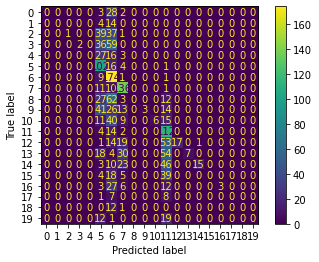

In [185]:
dist = ConfusionMatrixDisplay(heat_data)
dist.plot()
plt.show()

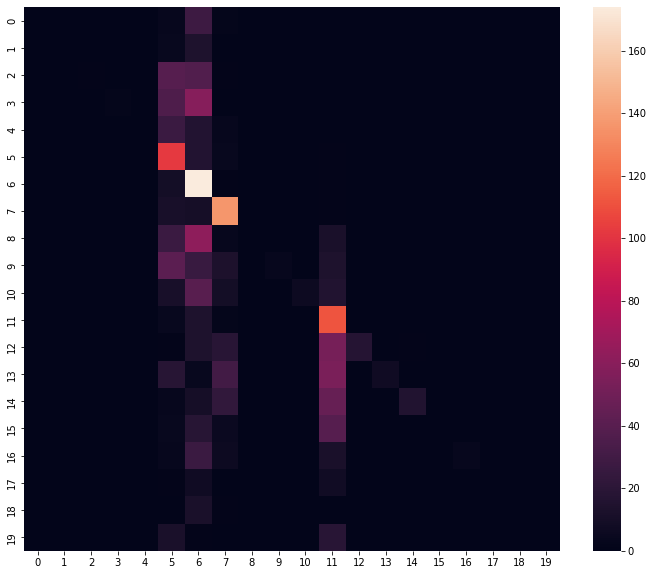

In [188]:
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(data = heat_data)

plt.show()

In [193]:
ch.author.nunique()

41

from the value_counts of the test_data and from the heatmap it can be seen that our model likes to predict the decades that it has been fed the most.
But nonetheless: 35% accuracy.

better than random, so it could be worse :) I wished the predictions would have been closer to the principal diagonal of the heatmap though.

Interesting observation to note: The predicted labels for 2, 3, 9, 10, 12, 13, 16 (and almost 14) have all been correct! 

The corresponding decades are: 1760, 1770, 1830, 1840, 1860, 1870, 1900.

So the machine only used these labels if it was (almost) certain the label was correct! 
Maybe some works from these decade use quite unique words, that are not seen in other decades. These could very well be Character Names or places that were mentioned. If these special words are missing it takes the "safe" decades which the machine was trained with the most.

## Ideas for improvement:
- As mentioned before we saw that our data is skewed. We can collect more data or limit the amount of chapter from each decade.
- Get more authors in exchange for a maximum number of titles from each author for a more diverse training. Right now we only have 41 authors.
- Don't limit the number of tokens for training the model. Maybe because of the limited amount of words the AI could not get the 'essence' of the chapter for classification
- Try other classification models
- remove stop-words in preprocessing
- Remove Character names and names of places from the tokens.
- Try not to predict the decade but the era/period (e.g. baroque, classicism, romanticism). If some author has the most publications e.g. in the years 1809 - 1811, then the categorization into different decades seems arbitrary for the machine. Style differences among different eras (and therefore maybe also among authors) might be easier to grasp for classification models.

## Iteration using all the tokens


In [194]:
ch['strings'] = ch['tokens'].apply(lambda x: ' '.join(x))

In [195]:
X = ch.strings
y = ch.decade

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.85, random_state=42)

In [197]:
count_vector = CountVectorizer()
X_train_counts = count_vector.fit_transform(X_train)

In [198]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [199]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [200]:
X_test_counts = count_vector.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [201]:
y_pred = clf.predict(X_test_tfidf)

In [202]:
from sklearn.metrics import accuracy_score

In [203]:
accuracy_score(y_test, y_pred)

0.3386018237082067

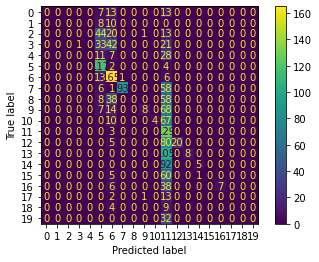

In [204]:
dist = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
dist.plot()
plt.show()

-> not so great

But you can say that the same observations hold more or less true in this case

## Limit decades and train chapters

In [206]:
ch.decade.value_counts()

1800    1154
1810    1036
1850     905
1790     848
1870     710
1770     698
1880     686
1860     674
1830     670
1820     641
1840     569
1760     524
1890     414
1900     411
1780     339
1930     214
1740     181
1750     116
1910      94
1920      79
Name: decade, dtype: int64

In [210]:
ch_1790 = ch.loc[ch.decade == '1790'].sample(500)
ch_1800 = ch.loc[ch.decade == '1800'].sample(500)
ch_1810 = ch.loc[ch.decade == '1810'].sample(500)
ch_1820 = ch.loc[ch.decade == '1820'].sample(500)
ch_1830 = ch.loc[ch.decade == '1830'].sample(500)
ch_1840 = ch.loc[ch.decade == '1840'].sample(500)
ch_1850 = ch.loc[ch.decade == '1850'].sample(500)
ch_1860 = ch.loc[ch.decade == '1860'].sample(500)
ch_1870 = ch.loc[ch.decade == '1870'].sample(500)
ch_1880 = ch.loc[ch.decade == '1880'].sample(500)

In [213]:
df_list = [ch_1790, 
           ch_1800, 
           ch_1810, 
           ch_1820, 
           ch_1830, 
           ch_1840, 
           ch_1850, 
           ch_1860, 
           ch_1870, 
           ch_1880]

In [214]:
X = []
y = []
for df in df_list:
    X.extend(list(df.strings))
    y.extend(list(df.decade))

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.85, random_state=42)

In [216]:
count_vector = CountVectorizer()
X_train_counts = count_vector.fit_transform(X_train)

In [217]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [218]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [219]:
X_test_counts = count_vector.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [220]:
y_pred = clf.predict(X_test_tfidf)

In [221]:
from sklearn.metrics import accuracy_score

In [222]:
accuracy_score(y_test, y_pred)

0.5173333333333333

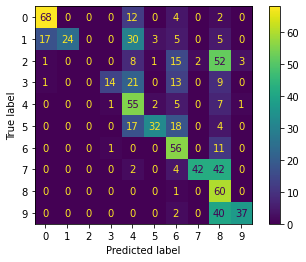

In [223]:
dist = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
dist.plot()
plt.show()